# TitaSink 

La compétition [Kaggle Titanic](https:,,www.kaggle.com,c,titanic) - Machine Learning from Disaster est l'une des plus en vogue pour commencer le Machine Learning. Elle met à disposition du public une base de données des passagers du Titanic ainsi que des détails concernant leur voyage. Le but est de prédire à l'aide de différentes techniques de Machine Learning les personnes qui ont survécu à la catastrophe. Ce notebook commence par explorer les arbres de décision (Decision Trees) pour effectuer cette classification. C'est une technique qui a fait ses preuves, mais qui fonctionne toujours aussi bien sur ces taches de classification.

## Reste à faire 
- Explication de la heat map et des correlations 
- Intérêt de batch normalisation pour un petit dataset
- Grid Search pour trouver la profondeur optimale de l'arbre dans les différentes phases de l'entraînement 
- Explication du plot-tree avec les paramètres et la fonction gini 

***
On commence par importer les bibliothèques nécessaires au projet. La lecture du fichier fourni `train.csv` est effectuée par la bibliothèque Pandas qui est très connue pour manipuler des bases de données. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
cwd = os.getcwd()

In [3]:
path = os.path.join(cwd,'train.csv')
print(path)
data = pd.read_csv(path)

C:\Users\VArri\Documents\GitHub\TitaSink\train.csv


***
La tête de la base de données renseigne sur les différents attributs disponibles pour donner des informations sur chaque passager. La colonne Ticket reste relativement incompréhensible, de même que la colonne Cabin dans laquelle il manque beaucoup de valeurs. La colonne SibSp renseigne pour chaque passager le nombre de parents à bord sur un même niveau généalogique (épouse/mari, frère/soeur, cousin/cousine, ...). La colonne Parch renseigne pour chaque passager le nombre de parents à bord avec un niveau généalogique différent (père/mère, fille/fils, ...).

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


***
La commande suivante permet de décrire les statistiques des variables numériques. Un premier aperçu des différentes valeurs permet de visualiser la dispersion des données et de localiser s'il y en a des valeurs suspectes (outliers) : un extremum inattendu qui fait référence à des valeurs impossibles, ... Le compte permet de visualiser la proportion de valeurs manquantes (missing values).

In [5]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


***
La fonction `pandas.Dataframe.isna()` est dédiée uniquement au décompte de missing value pour les variables typées int64. On peut alors voir que l'attribut Age comptabilise beaucoup de missing values (20%), l'attribut Ticket encore plus (77%) et l'attribut Embarked seulement quelques-unes (0.2%). On sait qu'un attribut avec plus de 40% de missing value n'est pas exploitable. Cette fonction nous permet d'avoir une première information sur les attributs qui vont devoir être supprimés, et ceux dont les missing value vont devoir être "inputées".

In [6]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

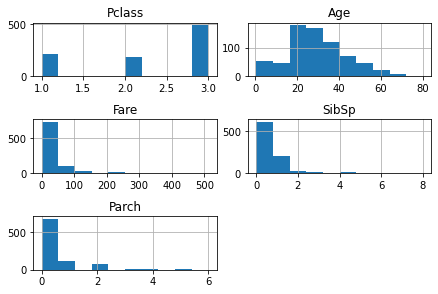

In [7]:
data.hist(column=['Pclass','Sex','Age','Fare', 'SibSp', 'Parch'])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [8]:
def preprocess(data, onehot=True):
    
    data['Sex'].replace(['female','male'],[0,1], inplace=True) 
    # l'attribut Sex est DANS CE DATASET binaire. 
    # On peut donc facilement remplacer les valeurs de cet attribut par des valeurs binaires.
    # Noter que l'argument inplace de la fonction permet d'avoir une transformation sous forme 
    # de procédure plutôt que sous forme de fonction. Cela permet d'éviter le recopiage mémoire du dataset.
    
    data.drop(columns=['Name', 'Cabin', 'Ticket','PassengerId'], inplace=True) 
    # On supprime du dataset les colonnes qui ne présentent pas d'intérêt pour la classification 
    # L'attribut Cabin présente trop de missing value NaN
    # L'attribut Ticket est assez indéchiffrable 
    # Le Nom ne présente pas d'intérêt pour la complexité de cette étude. Peut-être qu'une étude NLP pourrait 
    # montrer des dépendances entre le nom et la survivabilité du passager en fonction de son origine (réaction 
    # différente face au danger en fonction des origines ? ). 
    
    data['Embarked'].fillna('C', inplace=True) 
    # L'attribut Embarked a 2 missing values. On peut penser que les remplir aléatoirement est une bonne idée 
    # dans une première approximation sans avoir d'autres idées sur les dépendances inter-attributs. Est-ce que cette 
    # technique peut quand même générer des outliers si des dépendances existent entre les attributs ? 
    
    index = data[data['Age'].isna()].index # REALLY IMPORTANT
    value = np.absolute(np.random.normal(loc=data['Age'].mean(), scale=data['Age'].std(), size=data['Age'].isna().sum()))
    data['Age'].fillna(pd.Series(value, index=index), inplace=True)    
    # L'attribut Age présente beaucoup de missing values. Sans information supplémentaire, remplir les valeurs 
    # manquantes avec une loi normale est une solution simple et efficace. Cependant, compte tenu du nombre important 
    # de missing value, peut-être qu'avoir des informations avant d'inputer les missing values serait bénéfique pour ne 
    # pas influer trop sur l'information contenue dans le dataset par l'attribut Age.
    # https://stackoverflow.com/questions/53104625/pandas-fill-in-missing-values-choosing-values-from-a-normal-distribution
    
    if onehot:
        data = pd.get_dummies(data, columns=['Pclass', 'Embarked'])
        # Enfin, les variables categorical se doivent d'être one-hot encoded pour conserver l'information de classes 
        # sous forme numérique. Chaque valeur possible l'attribut apporte une colonne binaire supplémentaire dans le 
        # dataset final. 
    else:
        True
    
    return data

***
On commence par observer les distribution et dépendences parmi les différents attributs sans procéder au one-hot encoding pour les attributs catégoriques. 

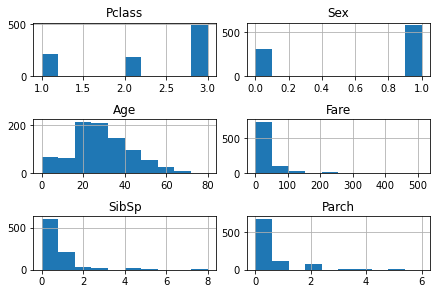

In [9]:
data_display = data.copy()
preprocess(data_display, onehot=False)

data_display.hist(column=['Pclass','Sex','Age','Fare', 'SibSp', 'Parch'])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

### Explication de la heat map entre les variables correlées ? 

<AxesSubplot:>

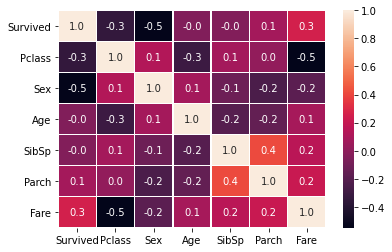

In [10]:
sns.heatmap(data_display.corr(), annot=True,linewidth=.5,fmt='.1f')

***
La première chose à faire pour le prétraitement d'une base de données est de la séparer en une partie entraînement et une partie validation. Cette opération permet pour les phases suivantes de remplissage de valeurs manquantes sur critères statistiques que les données contenues dans le jeu de données de validation n'influent pas sur l'entraînement du modèle. En effet, si cette séparation n'est pas effectuée au bon moment, une partie des informations du dataset de validation passe dans le processus d'entraînement et l'évaluation de la validation ne donne pas une valeur fiable de la précision. Après avoir réalisé la séparation, on effectue le prétraitement.

In [11]:
n=80

X_train = data.drop('Survived', axis=1).head(int(len(data)*n/100))
X_train = preprocess(X_train)
Y_train = data['Survived'].head(int(len(data)*n/100))

X_val = data.drop('Survived', axis=1).tail(int(len(data)*(100-n)/100)+1)
X_val = preprocess(X_val)
Y_val = data['Survived'].tail(int(len(data)*(100-n)/100)+1)

In [12]:
data.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0,1,22.0,1,0,7.2500,0,0,1,0,0,1
1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0
2,1,0,26.0,0,0,7.9250,0,0,1,0,0,1
3,1,0,35.0,1,0,53.1000,1,0,0,0,0,1
4,0,1,35.0,0,0,8.0500,0,0,1,0,0,1


***
On procède maintenant à la normalisation des données avant d'être données comme entrées au modèle de classification. La normalisation permet, indépendamment pour chaque attribut, d'avoir des valeurs comprises entre 0 et 1 ce qui convient bien au mécanisme d'activation pour les réseaux de neurones et qui permet de ne pas concentrer l'optimisation sur un attribut qui aurait une plage de valeurs plus large que d'autres attributs. La normalisation est réalisée en calculant la moyenne et l'écart-type pour chaque attribut puis en soustrayant et divisant ces attributs avec ces mêmes paramètres statistiques. À noter que le calcul des paramètres statistiques est effectué seulement sur les données d'entraînement et sera réutilisé tout du long pour la normalisation d'autres données d'entrée, toujours pour éviter le phénomène de transfert d'informations d'un processus vers un autre. 

In [13]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
# Fit to data, then transform it.
X_val = scaler.transform(X_val)
# Transform the data with previous statistical parameters
# https://datascience.stackexchange.com/questions/38395/standardscaler-before-and-after-splitting-data

***
On commence par importer le modèle d'arbre de décision depuis la bibliothèque SKLearn. Pour une complexité faible, on commence par une profondeur dans l'arbre de décision de 3. Ensuite, on peut fitter directement les paramètres de l'arbre au dataset d'entraînement que l'on a construit.&nbsp;

In [14]:
# Let us start by Decision Tree Classifier from SKLEARN PACKAGES
import sklearn as sk 
from sklearn.tree import DecisionTreeClassifier

TreeClf = DecisionTreeClassifier(max_depth=3)
TreeClf.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3)

In [15]:
score = TreeClf.score(X_train, Y_train)
score

0.8047752808988764

[Text(167.4, 190.26, 'X[0] <= -0.293\ngini = 0.476\nsamples = 712\nvalue = [434, 278]'),
 Text(83.7, 135.9, 'X[7] <= -0.096\ngini = 0.383\nsamples = 256\nvalue = [66, 190]'),
 Text(41.85, 81.53999999999999, 'X[1] <= -1.867\ngini = 0.098\nsamples = 135\nvalue = [7, 128]'),
 Text(20.925, 27.180000000000007, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(62.775000000000006, 27.180000000000007, 'gini = 0.086\nsamples = 133\nvalue = [6, 127]'),
 Text(125.55000000000001, 81.53999999999999, 'X[4] <= -0.158\ngini = 0.5\nsamples = 121\nvalue = [59, 62]'),
 Text(104.625, 27.180000000000007, 'gini = 0.486\nsamples = 103\nvalue = [43, 60]'),
 Text(146.475, 27.180000000000007, 'gini = 0.198\nsamples = 18\nvalue = [16, 2]'),
 Text(251.10000000000002, 135.9, 'X[5] <= 0.59\ngini = 0.311\nsamples = 456\nvalue = [368, 88]'),
 Text(209.25, 81.53999999999999, 'X[1] <= -1.809\ngini = 0.247\nsamples = 354\nvalue = [303, 51]'),
 Text(188.32500000000002, 27.180000000000007, 'gini = 0.497\nsamples = 13\nval

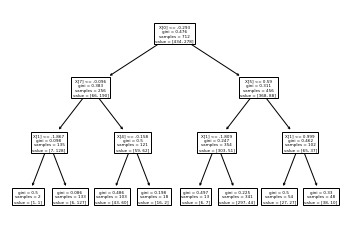

In [16]:
sk.tree.plot_tree(TreeClf)

***
Un premier arbre de décision avec une profondeur faible de 3 donne déjà de très bons résultats sur la prédiction des données d'entraînement. Voyons par la suite comment il généralise à de nouvelles données.

In [17]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(TreeClf.predict(X_val), Y_val)
acc

0.8491620111731844

***
Avant d'effectuer la prédiction sur les données du fichier `test.csv`, il faut ré entraîner l'arbre de décision sur l'ensemble des données d'entraînement disponibles pour que le modèle assimile un maximum d'informations et soit capable de mieux généraliser à de nouvelles données. On effectue donc une nouvelle normalisation pour entraîner un nouvel arbre de décision. Comme la quantité assimilée par l'arbre de décision a augmenté, la profondeur d'arbre optimale pourrait être différente de la précédente. Pour un premier essai, on ne s'intéressera pas à l'optimisation fine des hyperparamètres.

In [18]:
X_TOT = data.drop('Survived', axis=1)
scaler_TOT=StandardScaler()
X_TOT = scaler_TOT.fit_transform(X_TOT)

TreeClf_TOT = DecisionTreeClassifier(max_depth=3)
TreeClf_TOT.fit(X_TOT, data['Survived'])

DecisionTreeClassifier(max_depth=3)

In [19]:
path = os.path.join(cwd,'test.csv')
print(path)
test = pd.read_csv(path)

C:\Users\VArri\Documents\GitHub\TitaSink\test.csv


In [20]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [21]:
X_test = preprocess(test)
X_test

,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,34.500000,0,0,7.8292,0,0,1,0,1,0
1,0,47.000000,1,0,7.0000,0,0,1,0,0,1
2,1,62.000000,0,0,9.6875,0,1,0,0,1,0
3,1,27.000000,0,0,8.6625,0,0,1,0,0,1
4,0,22.000000,1,1,12.2875,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
413,1,12.638374,0,0,8.0500,0,0,1,0,0,1
414,0,39.000000,0,0,108.9000,1,0,0,1,0,0
415,1,38.500000,0,0,7.2500,0,0,1,0,0,1
416,1,50.576398,0,0,8.0500,0,0,1,0,0,1


In [22]:
X_test.isna().sum()

Sex           0
Age           0
SibSp         0
Parch         0
Fare          1
Pclass_1      0
Pclass_2      0
Pclass_3      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [23]:
X_test["Fare"].fillna(method='backfill', inplace=True)

In [24]:
X_test = scaler.transform(X_test)
predict = TreeClf_TOT.predict(X_test)

In [25]:
np.size(predict)

418

In [26]:
import csv
with open('submission.csv', 'w', newline='') as csvfile:
    Pred_writer = csv.writer(csvfile, delimiter=',')
    Pred_writer.writerow(['PassengerId','Survived'])
    for i in range(len(predict)):
        Pred_writer.writerow([892+i, predict[i]])